In [13]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is

import utils.db as db
import utils.parser as parser

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#%%time

# Fetch data
data = list(
    db.qa().AppUpdateLog.find()
)
data_with_indices = list(map(lambda data_entry: {**data_entry, **{'log': parser.add_index(data_entry['log'])}}, data))

In [15]:
# Process data
df = pd.DataFrame(data_with_indices)
df[['version', 'attempts']] = df.apply(lambda x: pd.Series([x.log[-1]['clientVersion'], x.log[-1]['index']]), axis=1)
df = pd.DataFrame({
    'timestamp': df['updatedAt'], 
    'user': df['userId'],
    'os': df['clientType'],
    'version': df['version'],
    'status': df['status'],
    'attempts': df['attempts'],
    'log': df['log']
})

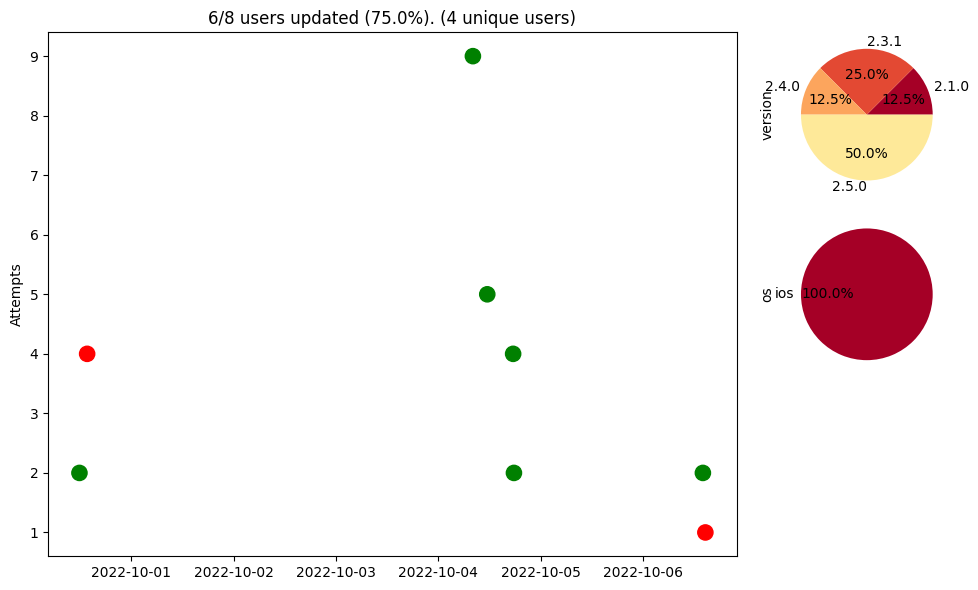

In [16]:
# Render data
plt.figure(figsize=(10, 6), dpi=100)

######### LEFT #########
ax1 = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=3)

colors = np.where(df.status == 'succeeded', 'g', 'r')
# weights = [200*i for i in df['attempts'].values for j in range(i)]
ax1.scatter(df.timestamp, df.attempts, s=120, c=colors)

total = len(df)
succeeded = len(df[df['status'] == 'succeeded'])
pct = abs(succeeded / (total / 100))

title = '{suceeded}/{total} users updated ({pct}%). ({unique} unique users)'.format(suceeded=succeeded, pct=pct, total=total, unique=len(df['user'].unique()))
plt.title(title)
plt.ylabel('Attempts')

######### TOP-RIGHT #########
ax2 = plt.subplot2grid((3, 4), (0, 3), rowspan=1)
plot = df.version\
          .groupby(df.version)\
          .count()\
          .plot(ax=ax2, 
                kind='pie',
                autopct='%1.1f%%', 
                colors=plt.cm.RdYlGn(np.linspace(0,1,len(df))))

######### CENTER-RIGHT #########
ax3 = plt.subplot2grid((3, 4), (1, 3), rowspan=1)
plot2 = df.os\
           .groupby(df.os)\
           .count()\
           .plot(ax=ax3, 
                 kind='pie',
                 autopct='%1.1f%%', 
                 colors=plt.cm.RdYlGn(np.linspace(0,1,len(df))))

plt.tight_layout()